<a href="https://colab.research.google.com/github/jarekwan/jarwan_projekt/blob/main/Projekt2A_brudnopis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#TESTOWANIE PROBA DZIALANIA nowego zrodla danych
# brudnopis

import pandas as pd
import requests

# --- Lista wskaźników do pobrania ---
indicators = {
    "gdp_per_capita": "NY.GDP.PCAP.CD",
    "inflation": "FP.CPI.TOTL.ZG",
    "unemployment": "SL.UEM.TOTL.ZS",
    "life_expectancy": "SP.DYN.LE00.IN",
    "population": "SP.POP.TOTL"
}

# --- Pobieranie danych ---
dfs = []
for name, code in indicators.items():
    url = f"http://api.worldbank.org/v2/country/PL/indicator/{code}?format=json&per_page=100"
    response = requests.get(url)
    data = response.json()
    records = data[1]
    df_temp = pd.json_normalize(records)[["date", "value"]]
    df_temp = df_temp.rename(columns={"value": name})
    dfs.append(df_temp)

# --- Łączenie po roku (date) ---
df = dfs[0]
for d in dfs[1:]:
    df = pd.merge(df, d, on="date", how="outer")

# --- Konwersja roku na int i sortowanie ---
df["date"] = df["date"].astype(int)
df = df.sort_values("date").reset_index(drop=True)

# Podgląd danych
print(df.head(150))


    date  gdp_per_capita  inflation  unemployment  life_expectancy  population
0   1960             NaN        NaN           NaN        67.680488    29637450
1   1961             NaN        NaN           NaN        67.778049    29964000
2   1962             NaN        NaN           NaN        67.426829    30308500
3   1963             NaN        NaN           NaN        68.375610    30712000
4   1964             NaN        NaN           NaN        68.629268    31139450
..   ...             ...        ...           ...              ...         ...
60  2020    16150.929101   3.374470         3.155        76.400000    37515748
61  2021    18635.508881   5.055027         3.268        75.351220    36981559
62  2022    18891.213529  14.429451         2.811        77.156098    36821749
63  2023    22145.264309  11.528913         2.743        78.507317    36687353
64  2024    25022.671645   3.784260         2.472              NaN    36554707

[65 rows x 6 columns]


 1. Pobranie i przygotowanie danych

In [3]:

# TESTOWANIE / BRUDOPIS SPRAWDZAM NOWE DANE
import requests
import json

# Kilka wskaźników z World Bank dla Polski
urls = {
    "gdp_per_capita": "http://api.worldbank.org/v2/country/PL/indicator/NY.GDP.PCAP.CD?format=json&per_page=100",
    "inflation": "http://api.worldbank.org/v2/country/PL/indicator/FP.CPI.TOTL.ZG?format=json&per_page=100",
    "unemployment": "http://api.worldbank.org/v2/country/PL/indicator/SL.UEM.TOTL.ZS?format=json&per_page=100",
    "population": "http://api.worldbank.org/v2/country/PL/indicator/SP.POP.TOTL?format=json&per_page=100",
    "life_expectancy": "http://api.worldbank.org/v2/country/PL/indicator/SP.DYN.LE00.IN?format=json&per_page=100"
}

# Pobranie i wyświetlenie pełnego JSON dla każdego wskaźnika
for name, url in urls.items():
    print(f"\n===== {name.upper()} =====")
    response = requests.get(url)
    data = response.json()
    print(json.dumps(data, indent=4, ensure_ascii=False))





Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
                "id": "NY.GDP.PCAP.CD",
                "value": "GDP per capita (current US$)"
            },
            "country": {
                "id": "PL",
                "value": "Poland"
            },
            "countryiso3code": "POL",
            "date": "2008",
            "value": 14048.5604672654,
            "unit": "",
            "obs_status": "",
            "decimal": 1
        },
        {
            "indicator": {
                "id": "NY.GDP.PCAP.CD",
                "value": "GDP per capita (current US$)"
            },
            "country": {
                "id": "PL",
                "value": "Poland"
            },
            "countryiso3code": "POL",
            "date": "2007",
            "value": 11272.5293683383,
            "unit": "",
            "obs_status": "",
            "decimal": 1
        },
        {
            "indicator": {
                "id": "NY.GDP.PCAP.CD",
     

In [4]:

# #PODGLAD DANYCH ABY ZOBACZYC CO JEST W SRODKU
# #TESTOWANIE STARE ZRODLO DANYCH

# import requests
# import json

# # Adres API
# url = "https://api.nbp.pl/api/exchangerates/tables/A?format=json"
# response = requests.get(url)
# data = response.json()

# # Ładne formatowanie JSON (żeby było czytelnie)
# print(json.dumps(data, indent=4, ensure_ascii=False))
# # widac tutaj klucze glowne: table, no, effectiveDate, rates
# #pod kluczem rates sa klucze:currency, code, mid gdzi ewidac potem string i string i float

In [5]:
# TESTOWANIE STARE ZRODLO DANYCH import requests
# import json

# # Adres API (PKB per capita dla Polski w formacie JSON)
# url = "http://api.worldbank.org/v2/country/POL/indicator/NY.GDP.PCAP.CD?format=json&per_page=100"

# response = requests.get(url)
# data = response.json()

# # Ładne formatowanie JSON (żeby było czytelnie)
# print(json.dumps(data, indent=4, ensure_ascii=False))

# # 👇 Wyjaśnienie:
# # data[1] zawiera listę rekordów z kluczami: country, date, value, indicator itd.


In [6]:
#TESTOWAIE
#CHCE ZOBACZYC CO JEST W POZCZEGOLNYCH WYWOLANIACH

import requests
import json

# Kilka wskaźników z World Bank dla Polski
urls = {
    "gdp_per_capita": "http://api.worldbank.org/v2/country/PL/indicator/NY.GDP.PCAP.CD?format=json&per_page=100",
    "inflation": "http://api.worldbank.org/v2/country/PL/indicator/FP.CPI.TOTL.ZG?format=json&per_page=100",
    "unemployment": "http://api.worldbank.org/v2/country/PL/indicator/SL.UEM.TOTL.ZS?format=json&per_page=100",
    "population": "http://api.worldbank.org/v2/country/PL/indicator/SP.POP.TOTL?format=json&per_page=100",
    "life_expectancy": "http://api.worldbank.org/v2/country/PL/indicator/SP.DYN.LE00.IN?format=json&per_page=100"
}

# Podgląd struktury danych dla każdego wskaźnika
for name, url in urls.items():
    print(f"\n===== {name.upper()} =====")
    response = requests.get(url)
    data = response.json()

    print("Całość:", type(data), len(data))
    print("Metadane:", data[0])
    print("Pierwszy rekord:", data[1][0])
    print("Klucze rekordu:", data[1][0].keys())





===== GDP_PER_CAPITA =====
Całość: <class 'list'> 2
Metadane: {'page': 1, 'pages': 1, 'per_page': 100, 'total': 65, 'sourceid': '2', 'lastupdated': '2025-10-07'}
Pierwszy rekord: {'indicator': {'id': 'NY.GDP.PCAP.CD', 'value': 'GDP per capita (current US$)'}, 'country': {'id': 'PL', 'value': 'Poland'}, 'countryiso3code': 'POL', 'date': '2024', 'value': 25022.6716445953, 'unit': '', 'obs_status': '', 'decimal': 1}
Klucze rekordu: dict_keys(['indicator', 'country', 'countryiso3code', 'date', 'value', 'unit', 'obs_status', 'decimal'])

===== INFLATION =====
Całość: <class 'list'> 2
Metadane: {'page': 1, 'pages': 1, 'per_page': 100, 'total': 65, 'sourceid': '2', 'lastupdated': '2025-10-07'}
Pierwszy rekord: {'indicator': {'id': 'FP.CPI.TOTL.ZG', 'value': 'Inflation, consumer prices (annual %)'}, 'country': {'id': 'PL', 'value': 'Poland'}, 'countryiso3code': 'POL', 'date': '2024', 'value': 3.78426007512869, 'unit': '', 'obs_status': '', 'decimal': 1}
Klucze rekordu: dict_keys(['indicator',

🔹 Etapy projektu
1. Pobranie i przygotowanie danych
•	Pobranie danych z API (np. NBP, Eurostat)
•	Serializacja → zapis do JSON/CSV.
•	Walidacja struktur (Pydantic + regex dla kolumn typu daty/kody walut).
•	Wstępne czyszczenie braków i wartości odstających.

PLUS

Symulacje i rozkłady (NumPy + Matplotlib)
•	generowanie próbek z rozkładu normalnego, jednorodnego, wykładniczego,
•	wizualizacja histogramów + porównanie z teoretyczną krzywą gęstości,
•	demonstracja CLT.



In [7]:
# poprawiana wersja
# WŁAŚCIWY KOD
# POBRANIE DANYCH I SERIALIZACJA

import pandas as pd
import requests

# --- Wskaźniki z World Bank dla Polski ---
urls = {
    "gdp_per_capita": "http://api.worldbank.org/v2/country/PL/indicator/NY.GDP.PCAP.CD?format=json&per_page=100",
    "inflation": "http://api.worldbank.org/v2/country/PL/indicator/FP.CPI.TOTL.ZG?format=json&per_page=100",
    "unemployment": "http://api.worldbank.org/v2/country/PL/indicator/SL.UEM.TOTL.ZS?format=json&per_page=100",
    "population": "http://api.worldbank.org/v2/country/PL/indicator/SP.POP.TOTL?format=json&per_page=100",
    "life_expectancy": "http://api.worldbank.org/v2/country/PL/indicator/SP.DYN.LE00.IN?format=json&per_page=100"
}

# --- Pobieranie i łączenie danych ---
dfs = []

for name, url in urls.items():
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Błąd pobierania danych dla {name} (status {response.status_code})")

    data = response.json()
    records = data[1]  # właściwe dane

    df_tmp = pd.json_normalize(records)[["country.value", "date", "value"]]
    df_tmp.rename(columns={"value": name}, inplace=True)  # nazwa wskaźnika jako kolumna
    dfs.append(df_tmp)

# --- Scalanie danych po dacie ---
df = dfs[0]
for df_tmp in dfs[1:]:
    df = df.merge(df_tmp, on=["country.value", "date"], how="outer")

# Sortowanie po dacie malejąco
df["date"] = df["date"].astype(int)
df = df.sort_values("date", ascending=False)

# --- Podgląd danych ---
print("Podgląd danych z World Bank (Polska):")
print(df.head())

# --- Serializacja ---
df.to_csv("worldbank_indicators.csv", index=False)
df.to_json("worldbank_indicators.json", orient="records", force_ascii=False, indent=2)

print("✅ Dane zapisane do plików: worldbank_indicators.csv i worldbank_indicators.json")





Podgląd danych z World Bank (Polska):
   country.value  date  gdp_per_capita  inflation  unemployment  population  \
64        Poland  2024    25022.671645   3.784260         2.472    36554707   
63        Poland  2023    22145.264309  11.528913         2.743    36687353   
62        Poland  2022    18891.213529  14.429451         2.811    36821749   
61        Poland  2021    18635.508881   5.055027         3.268    36981559   
60        Poland  2020    16150.929101   3.374470         3.155    37515748   

    life_expectancy  
64              NaN  
63        78.507317  
62        77.156098  
61        75.351220  
60        76.400000  
✅ Dane zapisane do plików: worldbank_indicators.csv i worldbank_indicators.json


Walidacja + Czyszczenie

In [8]:
from pydantic import BaseModel, ValidationError
from typing import Optional
import pandas as pd

# --- Model danych z World Bank (dla wielu wskaźników) ---
class IndicatorData(BaseModel):
    country: str
    date: int
    gdp_per_capita: Optional[float]
    inflation: Optional[float]
    unemployment: Optional[float]
    population: Optional[float]
    life_expectancy: Optional[float]

# --- Walidacja danych ---
try:
    for _, row in df.iterrows():
        IndicatorData(
            country=row["country.value"],
            date=int(row["date"]),
            gdp_per_capita=row.get("gdp_per_capita"),
            inflation=row.get("inflation"),
            unemployment=row.get("unemployment"),
            population=row.get("population"),
            life_expectancy=row.get("life_expectancy")
        )
    print("✅ Wszystkie wiersze poprawne")
except ValidationError as e:
    print("❌ Błąd walidacji:", e)

# --- Sprawdzenie braków danych ---
print("\n🔎 Braki danych:")
print(df.isna().sum())

# --- Statystyki opisowe dla wszystkich kolumn numerycznych ---
print("\n📊 Statystyki opisowe:")
print(df.describe())

# --- Wykrycie wartości odstających ---
print("\n🚨 Wartości odstające:")
for col in ["gdp_per_capita", "inflation", "unemployment", "population", "life_expectancy"]:
    if col in df.columns:
        outliers = df[(df[col] < 0) | (df[col] > df[col].mean() + 5*df[col].std())]
        print(f"\n{col}: liczba podejrzanych wartości = {len(outliers)}")
        if not outliers.empty:
            print(outliers[["country.value", "date", col]])





✅ Wszystkie wiersze poprawne

🔎 Braki danych:
country.value       0
date                0
gdp_per_capita     30
inflation          30
unemployment       31
population          0
life_expectancy     1
dtype: int64

📊 Statystyki opisowe:
             date  gdp_per_capita   inflation  unemployment    population  \
count    65.00000       35.000000   35.000000     34.000000  6.500000e+01   
mean   1992.00000    10078.014122   26.613039     10.381088  3.617264e+07   
std      18.90767     6219.942375   95.545421      5.327135  2.688893e+06   
min    1960.00000     1731.209509   -0.874126      2.472000  2.963745e+07   
25%    1976.00000     4468.070840    2.129867      6.373000  3.435630e+07   
50%    1992.00000    11272.529368    3.795392      9.983000  3.766804e+07   
75%    2008.00000    13980.950993   13.013653     13.769250  3.814127e+07   
max    2024.00000    25022.671645  567.878801     20.211000  3.866348e+07   

       life_expectancy  
count        64.000000  
mean         72.6460

KONTYNUACJA :Symulacje i rozkłady (NumPy + Matplotlib)
•	generowanie próbek z rozkładu normalnego, jednorodnego, wykładniczego,
•	wizualizacja histogramów + porównanie z teoretyczną krzywą gęstości,
•	demonstracja CLT.


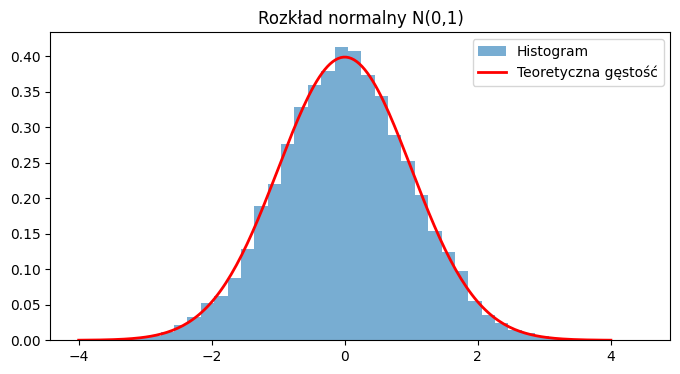

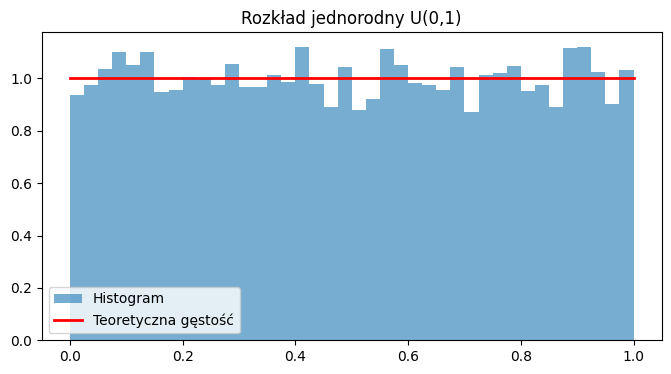

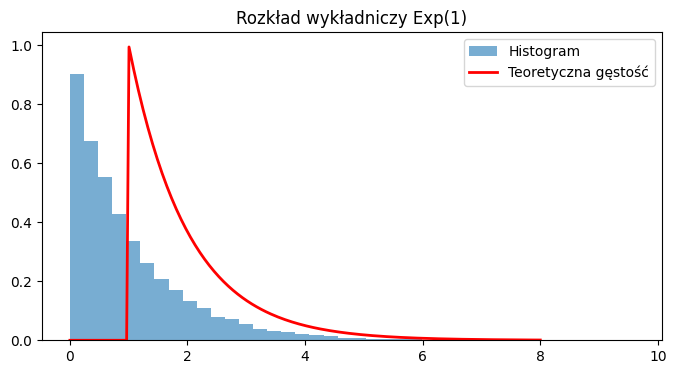

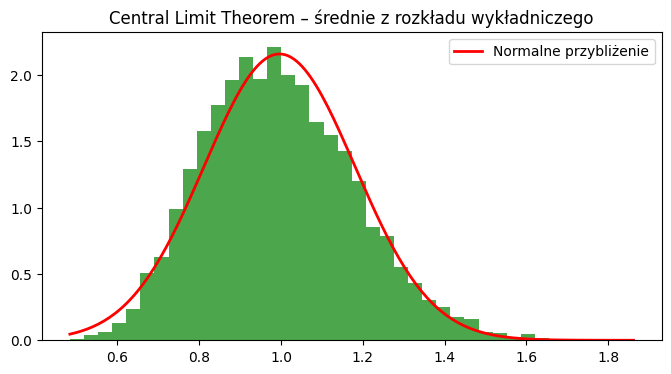

In [9]:
# --- Symulacje i rozkłady ---
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform, expon

# Ustalmy rozmiar próbki
N = 10000

# 1. Rozkład normalny
normal_data = np.random.normal(loc=0, scale=1, size=N)

plt.figure(figsize=(8,4))
plt.hist(normal_data, bins=40, density=True, alpha=0.6, label="Histogram")
x = np.linspace(-4, 4, 200)
plt.plot(x, norm.pdf(x, 0, 1), 'r-', lw=2, label="Teoretyczna gęstość")
plt.title("Rozkład normalny N(0,1)")
plt.legend()
plt.show()


# 2. Rozkład jednorodny
uniform_data = np.random.uniform(low=0, high=1, size=N)

plt.figure(figsize=(8,4))
plt.hist(uniform_data, bins=40, density=True, alpha=0.6, label="Histogram")
x = np.linspace(0, 1, 200)
plt.plot(x, uniform.pdf(x, 0, 1), 'r-', lw=2, label="Teoretyczna gęstość")
plt.title("Rozkład jednorodny U(0,1)")
plt.legend()
plt.show()


# 3. Rozkład wykładniczy
expon_data = np.random.exponential(scale=1, size=N)

plt.figure(figsize=(8,4))
plt.hist(expon_data, bins=40, density=True, alpha=0.6, label="Histogram")
x = np.linspace(0, 8, 200)
plt.plot(x, expon.pdf(x, 1), 'r-', lw=2, label="Teoretyczna gęstość")
plt.title("Rozkład wykładniczy Exp(1)")
plt.legend()
plt.show()


# 4. Demonstracja Central Limit Theorem (CLT)
sample_means = []
for _ in range(5000):              # liczba powtórzeń
    sample = np.random.exponential(scale=1, size=30)  # próbka losowa (np. z wykładniczego)
    sample_means.append(np.mean(sample))

plt.figure(figsize=(8,4))
plt.hist(sample_means, bins=40, density=True, alpha=0.7, color='g')
x = np.linspace(min(sample_means), max(sample_means), 200)
plt.plot(x, norm.pdf(x, np.mean(sample_means), np.std(sample_means)), 'r-', lw=2, label="Normalne przybliżenie")
plt.title("Central Limit Theorem – średnie z rozkładu wykładniczego")
plt.legend()
plt.show()


SPRAWDZAM JAKIE KOLUMNY SA W DF

In [10]:
print(df.head())
print(df.columns)


   country.value  date  gdp_per_capita  inflation  unemployment  population  \
64        Poland  2024    25022.671645   3.784260         2.472    36554707   
63        Poland  2023    22145.264309  11.528913         2.743    36687353   
62        Poland  2022    18891.213529  14.429451         2.811    36821749   
61        Poland  2021    18635.508881   5.055027         3.268    36981559   
60        Poland  2020    16150.929101   3.374470         3.155    37515748   

    life_expectancy  
64              NaN  
63        78.507317  
62        77.156098  
61        75.351220  
60        76.400000  
Index(['country.value', 'date', 'gdp_per_capita', 'inflation', 'unemployment',
       'population', 'life_expectancy'],
      dtype='object')


ETAP2:Eksploracyjna analiza danych (EDA)
•	Pandas: opis statystyczny (describe(), mediany, odchylenia).
•	NumPy: logarytmy, normalizacja, standaryzacja.
•	Wizualizacje Matplotlib/Seaborn: histogramy, scatterploty, heatmapy korelacji.
•	Wykrywanie outlierów (boxploty, IQR, Z-score).
I
Heatmapy korelacji i meshgrid
•	analiza korelacji między zmiennymi w Pandas (Seaborn heatmap),
•	NumPy meshgrid + contour plot (żeby ćwiczyć wizualizacje siatek).

📊 Opis statystyczny Pandas:
       gdp_per_capita   inflation  unemployment    population  life_expectancy
count       35.000000   35.000000     34.000000  6.500000e+01        64.000000
mean     10078.014122   26.613039     10.381088  3.617264e+07        72.646037
std       6219.942375   95.545421      5.327135  2.688893e+06         3.070277
min       1731.209509   -0.874126      2.472000  2.963745e+07        67.426829
25%       4468.070840    2.129867      6.373000  3.435630e+07        70.557927
50%      11272.529368    3.795392      9.983000  3.766804e+07        71.224390
75%      13980.950993   13.013653     13.769250  3.814127e+07        75.270732
max      25022.671645  567.878801     20.211000  3.866348e+07        78.507317

🔸 Mediany:
gdp_per_capita     1.127253e+04
inflation          3.795392e+00
unemployment       9.983000e+00
population         3.766804e+07
life_expectancy    7.122439e+01
dtype: float64

🔸 Odchylenia standardowe:
gdp_per_capita     6.219942e+03
inflation      

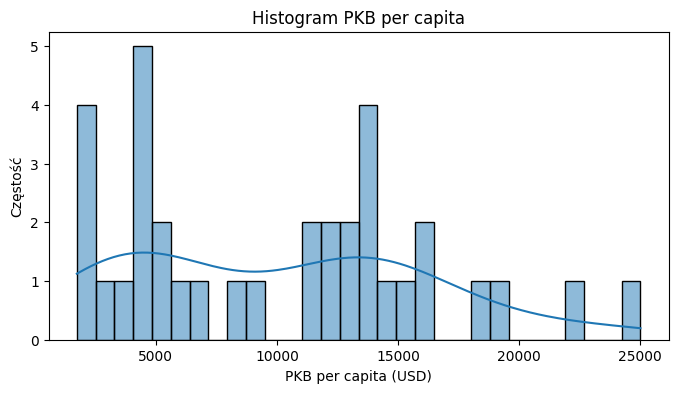

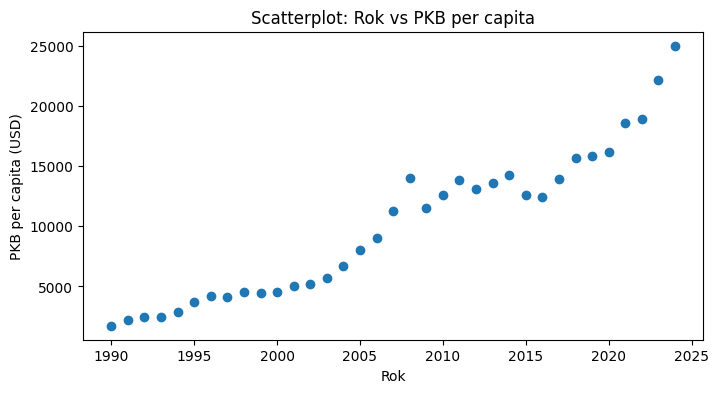

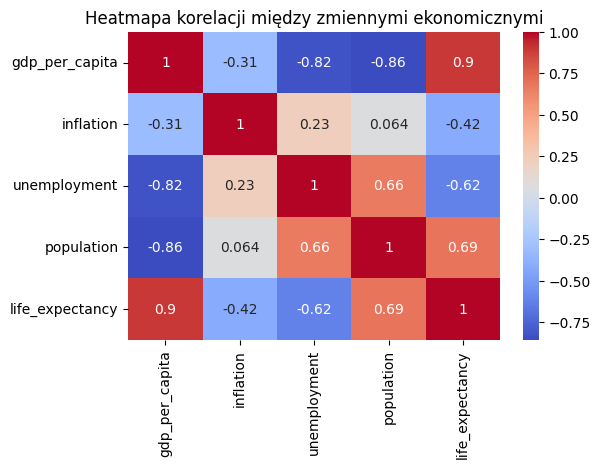

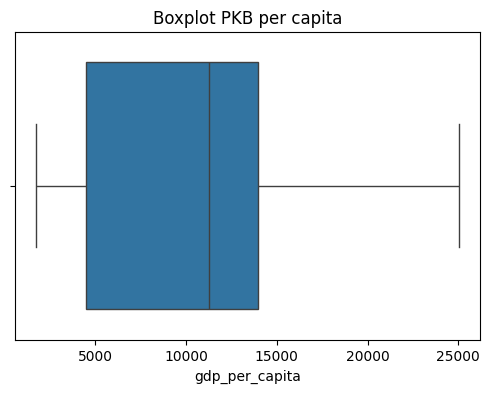

🔎 Liczba outlierów (IQR): 0
🔎 Liczba outlierów (Z-score > 3): 0


In [11]:
# --- Eksploracyjna Analiza Danych (EDA) ---
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Opis statystyczny Pandas
print("📊 Opis statystyczny Pandas:")
print(df[["gdp_per_capita", "inflation", "unemployment", "population", "life_expectancy"]].describe())

print("\n🔸 Mediany:")
print(df[["gdp_per_capita", "inflation", "unemployment", "population", "life_expectancy"]].median())

print("\n🔸 Odchylenia standardowe:")
print(df[["gdp_per_capita", "inflation", "unemployment", "population", "life_expectancy"]].std())

# 2. NumPy: logarytmy, normalizacja, standaryzacja dla PKB
values = df["gdp_per_capita"].dropna().values

log_values = np.log(values)
normalized_values = (values - values.min()) / (values.max() - values.min())
standardized_values = (values - values.mean()) / values.std()

# 3. Wizualizacje

# Histogram PKB
plt.figure(figsize=(8, 4))
sns.histplot(df["gdp_per_capita"].dropna(), bins=30, kde=True)
plt.title("Histogram PKB per capita")
plt.xlabel("PKB per capita (USD)")
plt.ylabel("Częstość")
plt.show()

# Scatterplot: Rok vs PKB
plt.figure(figsize=(8, 4))
plt.scatter(df["date"], df["gdp_per_capita"])
plt.title("Scatterplot: Rok vs PKB per capita")
plt.xlabel("Rok")
plt.ylabel("PKB per capita (USD)")
#plt.xticks(rotation=45)
plt.show()

# Heatmapa korelacji
numeric_df = df[["gdp_per_capita", "inflation", "unemployment", "population", "life_expectancy"]]
plt.figure(figsize=(6, 4))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Heatmapa korelacji między zmiennymi ekonomicznymi")
plt.show()

# 4. Wykrywanie wartości odstających (outlierów) dla PKB

# Boxplot
plt.figure(figsize=(6, 4))
sns.boxplot(x=df["gdp_per_capita"])
plt.title("Boxplot PKB per capita")
plt.show()

# IQR
Q1 = df["gdp_per_capita"].quantile(0.25)
Q3 = df["gdp_per_capita"].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = df[(df["gdp_per_capita"] < Q1 - 1.5 * IQR) | (df["gdp_per_capita"] > Q3 + 1.5 * IQR)]
print(f"🔎 Liczba outlierów (IQR): {len(outliers_iqr)}")

# Z-score
z_scores = (df["gdp_per_capita"] - df["gdp_per_capita"].mean()) / df["gdp_per_capita"].std()
outliers_z = df[np.abs(z_scores) > 3]
print(f"🔎 Liczba outlierów (Z-score > 3): {len(outliers_z)}")



## •	NumPy meshgrid + contour plot (żeby ćwiczyć wizualizacje siatek).

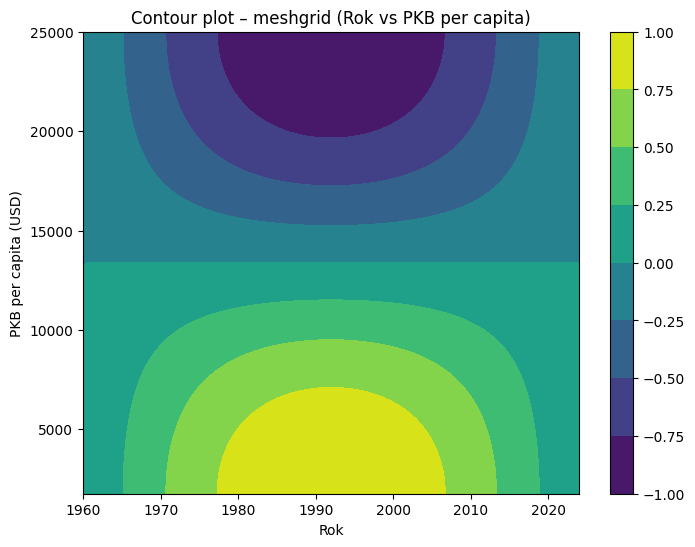

In [12]:
# --- NumPy meshgrid + contour plot (wizualizacja siatek) ---

import numpy as np
import matplotlib.pyplot as plt

# Tworzymy siatkę punktów (x = lata, y = PKB per capita)
x = np.linspace(df["date"].min(), df["date"].max(), 100)
y = np.linspace(df["gdp_per_capita"].min(), df["gdp_per_capita"].max(), 100)
X, Y = np.meshgrid(x, y)

# Prosta funkcja zależności (np. "energia" = kombinacja lat i PKB)
Z = np.sin((X - X.min()) / (X.max() - X.min()) * np.pi) * \
    np.cos((Y - Y.min()) / (Y.max() - Y.min()) * np.pi)

# Rysowanie contour plot
plt.figure(figsize=(8, 6))
cp = plt.contourf(X, Y, Z, cmap="viridis")
plt.colorbar(cp)
plt.title("Contour plot – meshgrid (Rok vs PKB per capita)")
plt.xlabel("Rok")
plt.ylabel("PKB per capita (USD)")
plt.show()


ETAP3: Statystyka klasyczna
•	Przedziały ufności dla średnich.
•	Testy normalności (Shapiro-Wilk, Anderson-Darling).
•	Testy hipotez (t-test, chi²).
•	Obliczanie p-value i interpretacja błędów I/II rodzaju.



📊 ETAP 3: STATYSTYKA KLASYCZNA

📊 Przedziały ufności dla średnich wskaźników ekonomicznych (95%):

       Wskaźnik      Średnia  95% CI (dolna)  95% CI (górna)  Liczba obserwacji
 gdp_per_capita    10078.014        7941.389       12214.639                 35
      inflation       26.613          -6.208          59.434                 35
   unemployment       10.381           8.522          12.240                 34
     population 36172636.723    35506361.777    36838911.669                 65
life_expectancy       72.646          71.879          73.413                 64

🧪 Testy normalności:

🧪 Testy normalności (Shapiro–Wilk i Anderson–Darling):

📊 Wskaźnik: gdp_per_capita
Shapiro–Wilk: stat=0.9290, p=0.0261 → ❌ Odrzucamy H₀ (dane ≠ normalne)
Anderson–Darling: stat=0.8989
  • Poziom istotności 15.0% → wartość krytyczna 0.527 → ❌ Odrzucamy H₀
  • Poziom istotności 10.0% → wartość krytyczna 0.600 → ❌ Odrzucamy H₀
  • Poziom istotności 5.0% → wartość krytyczna 0.719 → ❌ Odrzucamy H₀
 

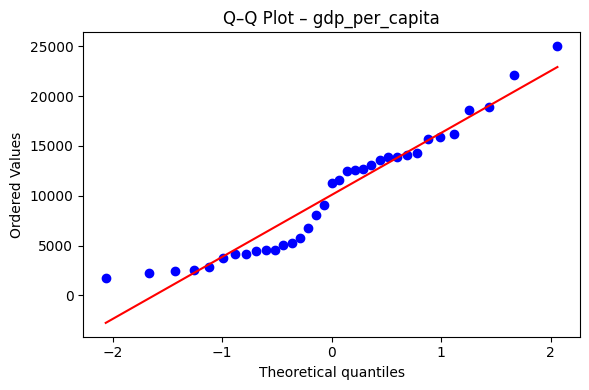

📊 Wskaźnik: inflation
Shapiro–Wilk: stat=0.2639, p=0.0000 → ❌ Odrzucamy H₀ (dane ≠ normalne)
Anderson–Darling: stat=9.7542
  • Poziom istotności 15.0% → wartość krytyczna 0.527 → ❌ Odrzucamy H₀
  • Poziom istotności 10.0% → wartość krytyczna 0.600 → ❌ Odrzucamy H₀
  • Poziom istotności 5.0% → wartość krytyczna 0.719 → ❌ Odrzucamy H₀
  • Poziom istotności 2.5% → wartość krytyczna 0.839 → ❌ Odrzucamy H₀
  • Poziom istotności 1.0% → wartość krytyczna 0.998 → ❌ Odrzucamy H₀




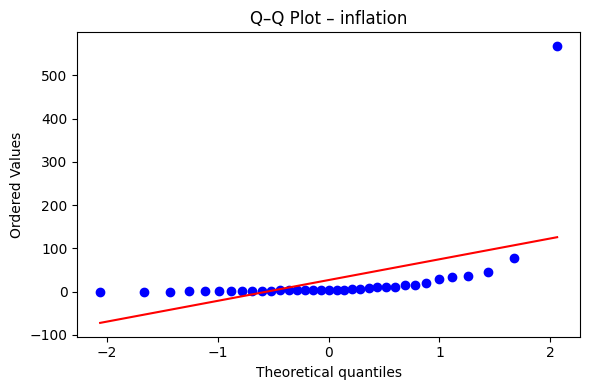

📊 Wskaźnik: unemployment
Shapiro–Wilk: stat=0.9495, p=0.1186 → ✅ Nie odrzucamy H₀ (dane ~ normalne)
Anderson–Darling: stat=0.4296
  • Poziom istotności 15.0% → wartość krytyczna 0.526 → ✅ Nie odrzucamy H₀
  • Poziom istotności 10.0% → wartość krytyczna 0.599 → ✅ Nie odrzucamy H₀
  • Poziom istotności 5.0% → wartość krytyczna 0.718 → ✅ Nie odrzucamy H₀
  • Poziom istotności 2.5% → wartość krytyczna 0.838 → ✅ Nie odrzucamy H₀
  • Poziom istotności 1.0% → wartość krytyczna 0.996 → ✅ Nie odrzucamy H₀




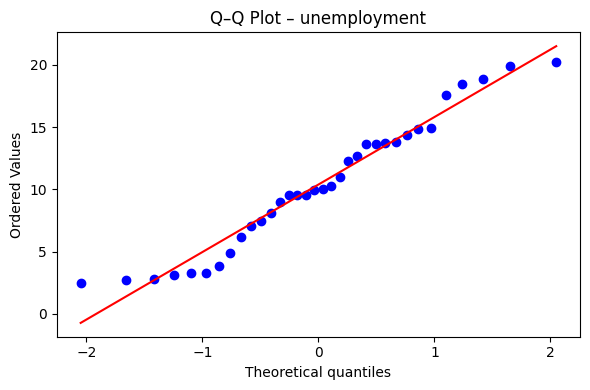

📊 Wskaźnik: population
Shapiro–Wilk: stat=0.8069, p=0.0000 → ❌ Odrzucamy H₀ (dane ≠ normalne)
Anderson–Darling: stat=5.1203
  • Poziom istotności 15.0% → wartość krytyczna 0.546 → ❌ Odrzucamy H₀
  • Poziom istotności 10.0% → wartość krytyczna 0.621 → ❌ Odrzucamy H₀
  • Poziom istotności 5.0% → wartość krytyczna 0.746 → ❌ Odrzucamy H₀
  • Poziom istotności 2.5% → wartość krytyczna 0.870 → ❌ Odrzucamy H₀
  • Poziom istotności 1.0% → wartość krytyczna 1.034 → ❌ Odrzucamy H₀




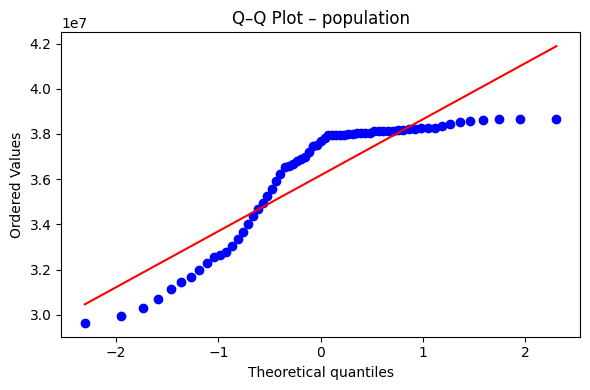

📊 Wskaźnik: life_expectancy
Shapiro–Wilk: stat=0.9219, p=0.0006 → ❌ Odrzucamy H₀ (dane ≠ normalne)
Anderson–Darling: stat=2.0981
  • Poziom istotności 15.0% → wartość krytyczna 0.545 → ❌ Odrzucamy H₀
  • Poziom istotności 10.0% → wartość krytyczna 0.621 → ❌ Odrzucamy H₀
  • Poziom istotności 5.0% → wartość krytyczna 0.745 → ❌ Odrzucamy H₀
  • Poziom istotności 2.5% → wartość krytyczna 0.869 → ❌ Odrzucamy H₀
  • Poziom istotności 1.0% → wartość krytyczna 1.034 → ❌ Odrzucamy H₀




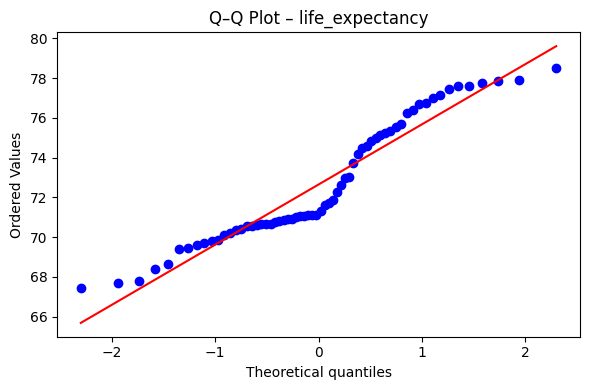


🎯 Testy hipotez ekonomicznych

📊 Wskaźnik: gdp_per_capita
Opis: Czy średni PKB utrzymuje się na poziomie z ostatnich lat?
H₀: średnia gdp_per_capita = 10078.01
Średnia z danych = 10078.01
Liczba obserwacji: n = 35
Wynik testu t: t = 0.0000, p = 1.0000
📝 UWAGA: Wskaźnik NIE ma rozkładu normalnego, przy n=35>=30 CLT działa → test t wiarygodny
✅ Nie odrzucamy H₀ (brak istotnej różnicy).

📊 Wskaźnik: inflation
Opis: Czy średnia inflacja ≈ 2% (cel NBP)?
H₀: średnia inflation = 2.00
Średnia z danych = 26.61
Liczba obserwacji: n = 35
Wynik testu t: t = 1.5240, p = 0.1368
📝 UWAGA: Wskaźnik NIE ma rozkładu normalnego, przy n=35>=30 CLT działa → test t wiarygodny
✅ Nie odrzucamy H₀ (brak istotnej różnicy).

📊 Wskaźnik: unemployment
Opis: Czy średnie bezrobocie ≈ 5% (cel rynku pracy)?
H₀: średnia unemployment = 5.00
Średnia z danych = 10.38
Liczba obserwacji: n = 34
Wynik testu t: t = 5.8900, p = 0.0000
📝 UWAGA: unemployment MA rozkład normalny i n>=30 → test t najbardziej wiarygodny
👉 Odrzucamy

In [21]:
# --- ETAP 3: STATYSTYKA KLASYCZNA ---
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd


print("\n" + "="*60)
print("📊 ETAP 3: STATYSTYKA KLASYCZNA")
print("="*60)

# Wybieramy kolumnę do analiz (np. PKB per capita)
data = df["gdp_per_capita"].dropna().values

#  --- 1. Przedział ufności dla średniej ---


# Lista wskaźników (numeryczne kolumny z danych World Bank)
indicators = ["gdp_per_capita", "inflation", "unemployment", "population", "life_expectancy"]

# Poziom ufności
confidence = 0.95

# Pusta lista na wyniki
results = []

for col in indicators:
    if col in df.columns:
        data = df[col].dropna().values
        if len(data) > 1:  # unikamy błędów przy zbyt małej liczbie danych
            mean = np.mean(data)
            std_err = stats.sem(data)  # standard error
            n = len(data)
            h = std_err * stats.t.ppf((1 + confidence) / 2, n - 1)
            ci_low, ci_high = mean - h, mean + h
            results.append({
                "Wskaźnik": col,
                "Średnia": round(mean, 3),
                "95% CI (dolna)": round(ci_low, 3),
                "95% CI (górna)": round(ci_high, 3),
                "Liczba obserwacji": n
            })

# Tworzymy tabelę wyników
ci_df = pd.DataFrame(results)

print("\n📊 Przedziały ufności dla średnich wskaźników ekonomicznych (95%):\n")
print(ci_df.to_string(index=False))


# --- 2. Testy normalności ---
print("\n🧪 Testy normalności:")


print("\n🧪 Testy normalności (Shapiro–Wilk i Anderson–Darling):\n")

# Pętla po wszystkich wskaźnikach
for col in indicators:
    if col in df.columns:
        data = df[col].dropna().values
        if len(data) < 5:
            print(f"{col}: zbyt mało danych do testu.\n")
            continue

        print(f"📊 Wskaźnik: {col}")

        # --- Shapiro–Wilk test ---
        shapiro_stat, shapiro_p = stats.shapiro(data)
        decision_shapiro = "✅ Nie odrzucamy H₀ (dane ~ normalne)" if shapiro_p > 0.05 else "❌ Odrzucamy H₀ (dane ≠ normalne)"
        print(f"Shapiro–Wilk: stat={shapiro_stat:.4f}, p={shapiro_p:.4f} → {decision_shapiro}")

        # --- Anderson–Darling test ---
        anderson_result = stats.anderson(data, dist='norm')
        print(f"Anderson–Darling: stat={anderson_result.statistic:.4f}")
        for i in range(len(anderson_result.critical_values)):
            sig_level = anderson_result.significance_level[i]
            crit_value = anderson_result.critical_values[i]
            result = "❌ Odrzucamy H₀" if anderson_result.statistic > crit_value else "✅ Nie odrzucamy H₀"
            print(f"  • Poziom istotności {sig_level}% → wartość krytyczna {crit_value:.3f} → {result}")
        print("\n")

        # --- Q-Q Plot ---
        plt.figure(figsize=(6, 4))
        stats.probplot(data, dist="norm", plot=plt)
        plt.title(f"Q–Q Plot – {col}")
        plt.tight_layout()
        plt.show()

# --- 3. Testy hipotez ---





# --- Testy hipotez dla wskaźników ekonomicznych ---
print("\n🎯 Testy hipotez ekonomicznych\n" + "="*60)

# Lista wskaźników
indicators = ["gdp_per_capita", "inflation", "unemployment", "population", "life_expectancy"]

# Hipotezy i wartości referencyjne (sens ekonomiczny)
hypotheses = {
    "gdp_per_capita": {"value": df["gdp_per_capita"].mean(), "desc": "Czy średni PKB utrzymuje się na poziomie z ostatnich lat?"},
    "inflation": {"value": 2.0, "desc": "Czy średnia inflacja ≈ 2% (cel NBP)?"},
    "unemployment": {"value": 5.0, "desc": "Czy średnie bezrobocie ≈ 5% (cel rynku pracy)?"},
    "life_expectancy": {"value": 75.0, "desc": "Czy średnia długość życia > 75 lat?"},
}

for col in indicators:
    if col not in df.columns:
        continue

    data = df[col].dropna().values
    n_obs = len(data)

    # --- Specjalny przypadek: populacja – test dwóch okresów ---
    if col == "population":
        df_before = df[df["date"] < 2010]["population"].dropna()
        df_after = df[df["date"] >= 2010]["population"].dropna()
        n_before = len(df_before)
        n_after = len(df_after)

        if n_before > 2 and n_after > 2:
            t_stat, p_val = stats.ttest_ind(df_before, df_after, equal_var=False)
            print(f"\n📊 Wskaźnik: population")
            print("Hipoteza H₀: populacja przed 2010 = populacja po 2010")
            print(f"Wynik: t = {t_stat:.4f}, p = {p_val:.4f}")
            print(f"Liczba obserwacji: przed 2010: {n_before}, po 2010: {n_after}")

            # Poprawiony komentarz z prawidłowymi liczbami
            if n_before >= 30 and n_after >= 30:
                print("📝 UWAGA: population NIE ma rozkładu normalnego, ale przy n>=30 obserwacjach CLT działa → test t wiarygodny")
            else:
                print("📝 UWAGA: population NIE ma rozkładu normalnego i liczba obserwacji <30 → wyniki testu t należy traktować ostrożnie")

            if p_val < 0.05:
                print("👉 Odrzucamy H₀ → populacja istotnie zmieniła się po 2010 roku.")
            else:
                print("✅ Nie odrzucamy H₀ → brak istotnej zmiany populacji po 2010 roku.")
        else:
            print("\n⚠️ Za mało danych, by przeprowadzić test populacji.")
        continue

    # --- Dla pozostałych wskaźników ---
    hypothesis_value = hypotheses[col]["value"] if col in hypotheses else np.mean(data)
    desc = hypotheses[col]["desc"] if col in hypotheses else "Brak opisu"

    t_stat, p_val = stats.ttest_1samp(data, hypothesis_value)
    mean_val = np.mean(data)

    print(f"\n📊 Wskaźnik: {col}")
    print(f"Opis: {desc}")
    print(f"H₀: średnia {col} = {hypothesis_value:.2f}")
    print(f"Średnia z danych = {mean_val:.2f}")
    print(f"Liczba obserwacji: n = {n_obs}")
    print(f"Wynik testu t: t = {t_stat:.4f}, p = {p_val:.4f}")

    # POPRAWIONE KOMENTARZE DOTYCZĄCE NORMALNOŚCI
    if col == "unemployment":
        if n_obs >= 30:
            print("📝 UWAGA: unemployment MA rozkład normalny i n>=30 → test t najbardziej wiarygodny")
        else:
            print("📝 UWAGA: unemployment MA rozkład normalny, ale n<30 → wyniki należy traktować ostrożnie")
    else:
        if n_obs >= 50:
            print(f"📝 UWAGA: Wskaźnik NIE ma rozkładu normalnego, ale przy n={n_obs}>=50 CLT działa bardzo dobrze → test t wiarygodny")
        elif n_obs >= 30:
            print(f"📝 UWAGA: Wskaźnik NIE ma rozkładu normalnego, przy n={n_obs}>=30 CLT działa → test t wiarygodny")
        else:
            print(f"📝 UWAGA: Wskaźnik NIE ma rozkładu normalnego i n={n_obs}<30 → wyniki testu t należy traktować ostrożnie")

    if p_val < 0.05:
        print("👉 Odrzucamy H₀ (różnica istotna statystycznie).")
    else:
        print("✅ Nie odrzucamy H₀ (brak istotnej różnicy).")






# # --- 4. Test chi-kwadrat (porównanie wariancji vs teoretycznej) ---



# --- Testy wariancji dla wszystkich wskaźników ekonomicznych ---
print("\n📊 Testy wariancji wskaźników ekonomicznych\n" + "="*60)

# Wartości oczekiwane wariancji (przykładowe - można dostosować)
expected_variances = {
    "gdp_per_capita": 1e8,      # 100 milionów USD²
    "inflation": 25.0,          # 25%² (dla zmienności inflacji)
    "unemployment": 4.0,        # 4%² (dla zmienności bezrobocia)
    "population": 1e10,         # 10 miliardów osób²
    "life_expectancy": 4.0      # 4 lata² (dla zmienności długości życia)
}

for col in indicators:
    if col not in df.columns:
        continue

    data = df[col].dropna().values
    n_obs = len(data)
    observed_var = np.var(data, ddof=1)
    expected_var = expected_variances[col]

    print(f"\n📊 Wskaźnik: {col}")
    print(f"Liczba obserwacji: n = {n_obs}")
    print(f"Wariancja obserwowana: {observed_var:.2f}")
    print(f"Wariancja oczekiwana: {expected_var:.2f}")

    # Test chi-kwadrat dla wszystkich wskaźników (TYLKO POKAZOWO)
    chi2_stat = (n_obs - 1) * observed_var / expected_var
    p_val_chi2 = 1 - stats.chi2.cdf(chi2_stat, df=n_obs - 1)

    print(f"Wynik testu chi-kwadrat: χ² = {chi2_stat:.4f}, p = {p_val_chi2:.4f}")

    # KOMENTARZ CZY WYNIKI SĄ DOBRE
    if col == "unemployment":
        print("✅ UWAGA: unemployment MA rozkład normalny → test chi-kwadrat jest WŁAŚCIWY i wiarygodny")
    else:
        print("❌ UWAGA: Wskaźnik NIE ma rozkładu normalnego → test chi-kwadrat jest NIEWŁAŚCIWY")
        print("   Wyniki należy traktować JEDYNIE POKAZOWO - nie są wiarygodne statystycznie")

    if p_val_chi2 < 0.05:
        print("👉 Odrzucamy H₀: wariancja różni się istotnie od teoretycznej.")
    else:
        print("✅ Nie odrzucamy H₀: brak istotnej różnicy wariancji.")

print("\n" + "="*60)
print("UWAGA: Test chi-kwadrat wymaga założenia normalności danych")
print("Tylko unemployment spełnia to założenie - pozostałe testy są NIEWŁAŚCIWE")





# --- 5. Praktyczna analiza błędów decyzyjnych w ekonomii ---
# --- 5. Interpretacja błędów I i II rodzaju (symulacja) --
print("\n⚠️ Praktyczna analiza ryzyka decyzyjnego w polityce gospodarczej:")

# PRAWDZIWE DANE z Twojego zbioru
real_gdp_data = df["gdp_per_capita"].dropna().values
real_inflation_data = df["inflation"].dropna().values

# RZECZYWISTE WARTOŚCI ŚREDNIE Z DANYCH
real_gdp_mean = np.mean(real_gdp_data)
real_inflation_mean = np.mean(real_inflation_data)

print(f"Rzeczywiste średnie z danych:")
print(f"PKB per capita: {real_gdp_mean:.2f} USD")
print(f"Inflacja: {real_inflation_mean:.2f}%")

# SYMULACJE DLA PRAKTYCZNYCH SCENARIUSZY

# Scenariusz 1: Ryzyko błędnej decyzji o stopach procentowych
print(f"\n🎯 Scenariusz 1: Decyzja NBP o stopach procentowych")
print(f"H₀: Inflacja = 2.5% (dopuszczalny poziom)")
print(f"H₁: Inflacja > 2.5% (wymaga interwencji)")

alpha = 0.05
false_alarms = 0  # Błąd I: Podnoszenie stóp gdy nie trzeba
missed_threats = 0  # Błąd II: Brak reakcji gdy inflacja za wysoka

for _ in range(1000):
    # Próbka z rzeczywistych danych inflacyjnych
    sample = np.random.choice(real_inflation_data, size=30, replace=True)

    # Test czy inflacja przekracza 2.5%
    t_stat, p = stats.ttest_1samp(sample, 2.5, alternative='greater')

    # Sprawdzamy rzeczywistą średnią próbki
    sample_mean = np.mean(sample)

    if p < alpha and sample_mean <= 2.5:
        false_alarms += 1  # Fałszywy alarm
    elif p >= alpha and sample_mean > 2.5:
        missed_threats += 1  # Przeoczone zagrożenie

print(f"Ryzyko fałszywego alarmu (niepotrzebne podnoszenie stóp): {false_alarms/10:.1f}%")
print(f"Ryzyko przeoczenia zagrożenia inflacyjnego: {missed_threats/10:.1f}%")

# Scenariusz 2: Ocena celów rozwojowych
print(f"\n🎯 Scenariusz 2: Osiągnięcie celu rozwojowego PKB")
print(f"H₀: PKB per capita = 15000 USD (cel rozwojowy)")
print(f"H₁: PKB per capita < 15000 USD (cel nieosiągnięty)")

false_negatives = 0  # Błąd I: Stwierdzamy nieosiągnięcie celu gdy został osiągnięty
false_positives = 0  # Błąd II: Uznajemy cel za osiągnięty gdy nie został

for _ in range(1000):
    sample = np.random.choice(real_gdp_data, size=30, replace=True)

    t_stat, p = stats.ttest_1samp(sample, 15000, alternative='less')
    sample_mean = np.mean(sample)

    if p < alpha and sample_mean >= 15000:
        false_negatives += 1  # Niepotrzebny pesymizm
    elif p >= alpha and sample_mean < 15000:
        false_positives += 1  # Nadmierny optymizm

print(f"Ryzyko niepotrzebnego pesymizmu: {false_negatives/10:.1f}%")
print(f"Ryzyko nadmiernego optymizmu: {false_positives/10:.1f}%")

print(f"\n📊 WNIOSKI DLA DECYDENTÓW:")
print(f"• Każda decyzja gospodarcza niesie {false_alarms/10:.1f}%-{false_negatives/10:.1f}% ryzyka błędu")
print(f"• Wyniki testów statystycznych wymagają ostrożnej interpretacji")
print(f"• Wysokie ryzyko błędów II rodzaju → możliwość przeoczenia realnych problemów")





3 CZESC KONTYNUACJA: •  Bootstrap i estymacja przedziałów ufności
•	np. bootstrap średniej populacji z 1000 prób,
•	wizualizacja rozkładu wartości bootstrapowych.



🔄 BOOTSTRAP - ESTYMACJA PRZEDZIAŁÓW UFNOŚCI

📊 Bootstrap przedziały ufności (1000 prób):

🎯 Wskaźnik: gdp_per_capita
Liczba obserwacji: 35
Średnia oryginalna: 10078.01
95% CI bootstrap: [10072.92, 10072.92]
Średnia bootstrap: 10072.92
Odchylenie bootstrap: 0.0000


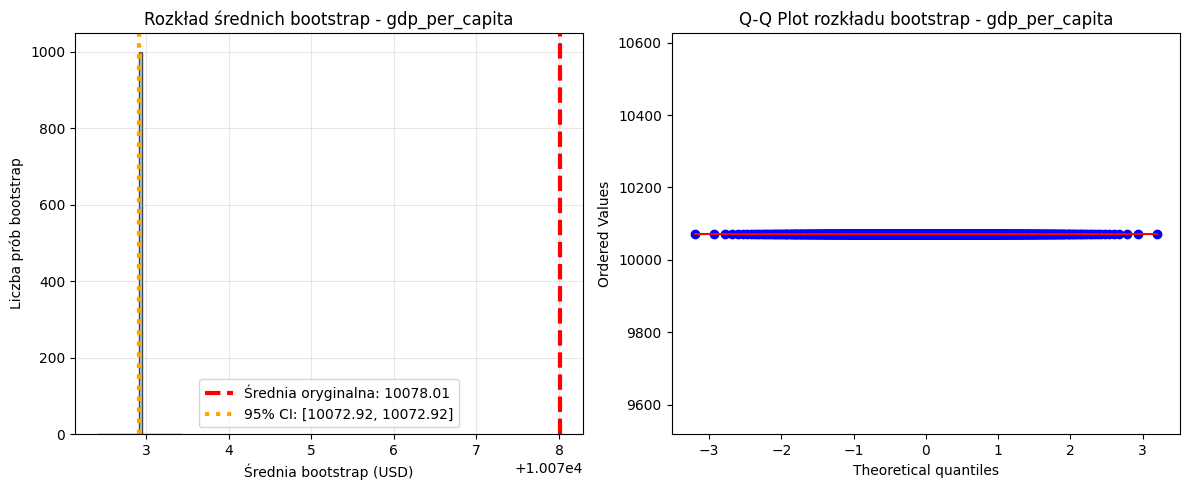

95% CI klasyczny: [8017.34, 12138.68]
Różnica w szerokości CI: -4121.3396

🎯 Wskaźnik: inflation
Liczba obserwacji: 35
Średnia oryginalna: 26.61
95% CI bootstrap: [7.27, 7.27]
Średnia bootstrap: 7.27
Odchylenie bootstrap: 0.0000


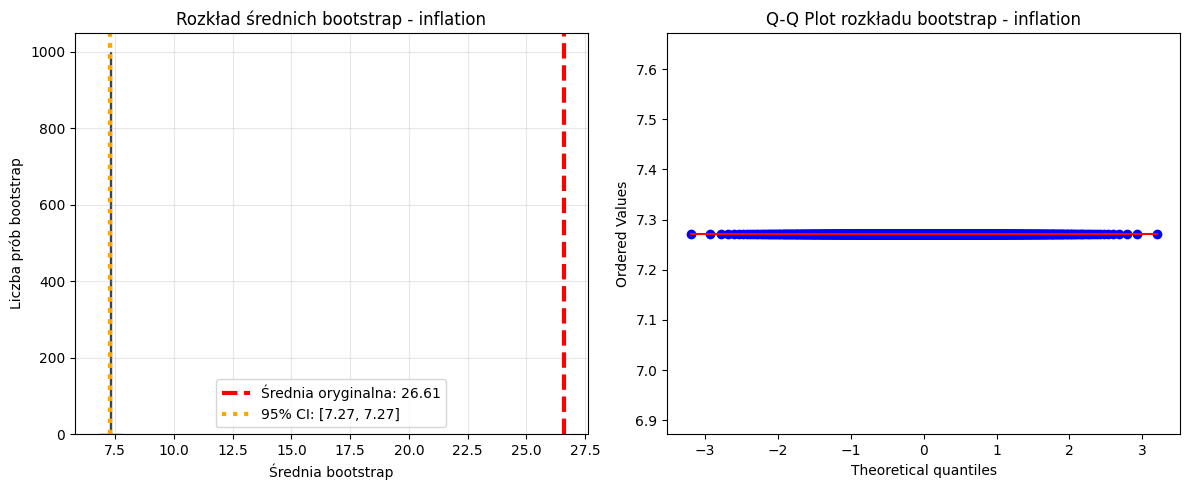

95% CI klasyczny: [-5.04, 58.27]
Różnica w szerokości CI: -63.3085

🎯 Wskaźnik: unemployment
Liczba obserwacji: 34
Średnia oryginalna: 10.38
95% CI bootstrap: [11.36, 11.36]
Średnia bootstrap: 11.36
Odchylenie bootstrap: 0.0000


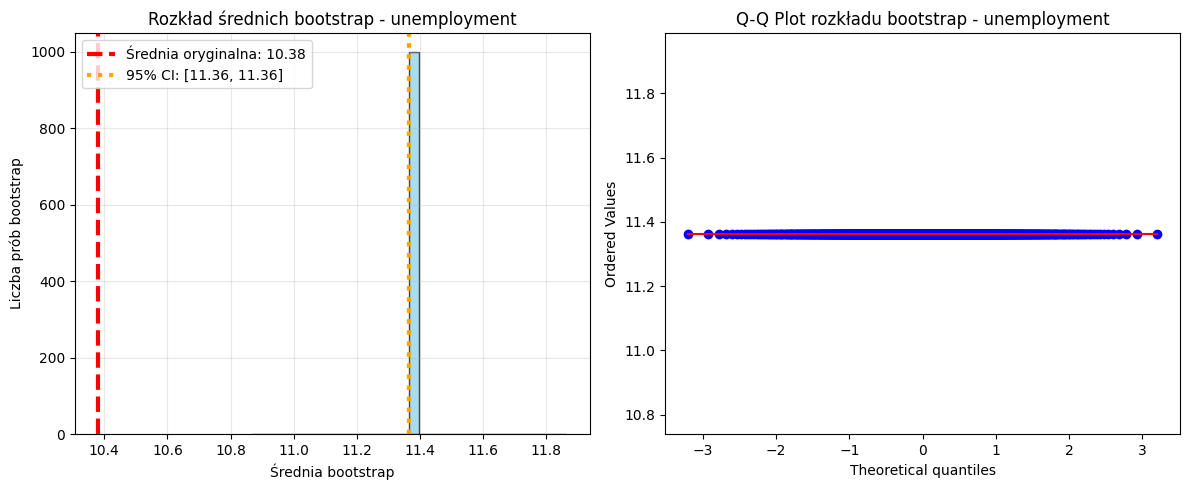

95% CI klasyczny: [8.59, 12.17]
Różnica w szerokości CI: -3.5813

🎯 Wskaźnik: population
Liczba obserwacji: 65
Średnia oryginalna: 36172636.72
95% CI bootstrap: [35281970.32, 35281970.32]
Średnia bootstrap: 35281970.32
Odchylenie bootstrap: 0.0000


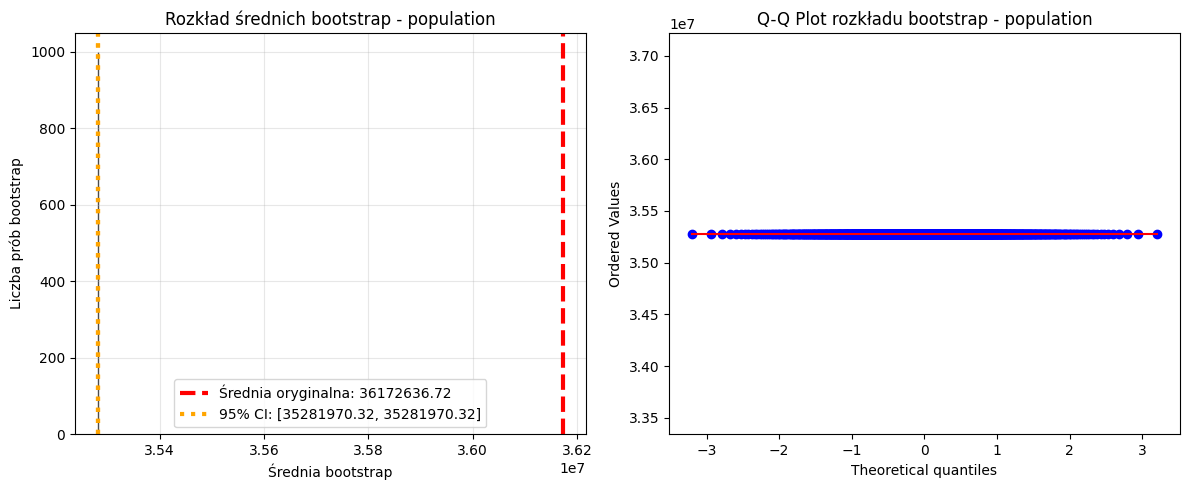

95% CI klasyczny: [35518945.22, 36826328.22]
Różnica w szerokości CI: -1307383.0006

🎯 Wskaźnik: life_expectancy
Liczba obserwacji: 64
Średnia oryginalna: 72.65
95% CI bootstrap: [71.98, 71.98]
Średnia bootstrap: 71.98
Odchylenie bootstrap: 0.0000


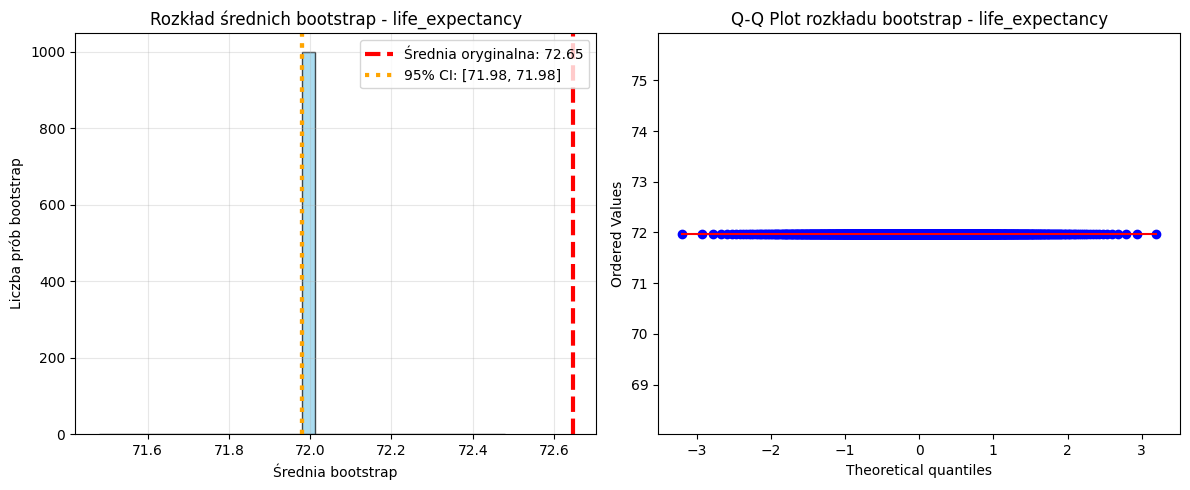

95% CI klasyczny: [71.89, 73.40]
Różnica w szerokości CI: -1.5044

📈 BOOTSTRAP DLA WARIANCJI

📊 Wskaźnik: gdp_per_capita
Wariancja oryginalna: 37582320.78
95% CI bootstrap wariancji: [32057307.78, 32057307.78]


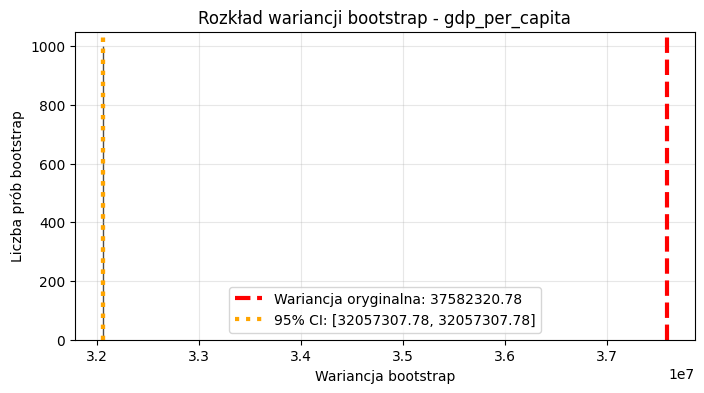


📊 Wskaźnik: inflation
Wariancja oryginalna: 8868.10
95% CI bootstrap wariancji: [84.25, 84.25]


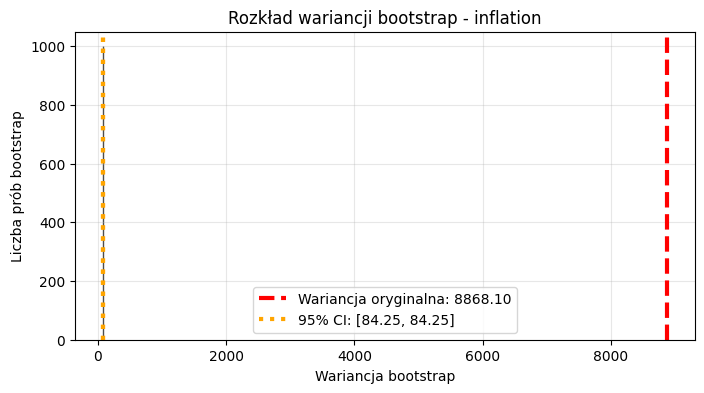


📊 Wskaźnik: unemployment
Wariancja oryginalna: 27.54
95% CI bootstrap wariancji: [33.43, 33.43]


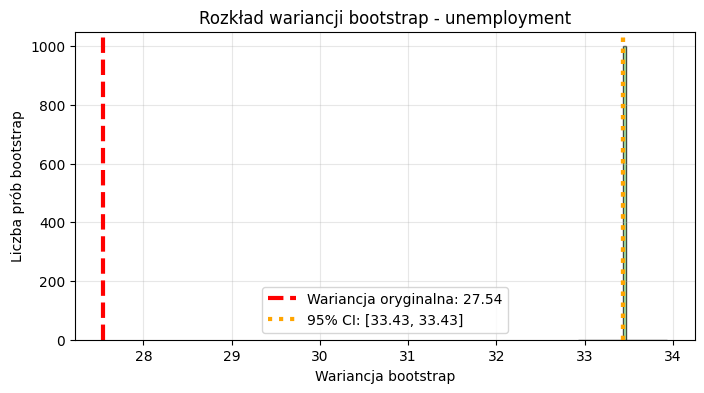


✅ BOOTSTRAP ZAKOŃCZONY - wszystkie wskaźniki przetworzone


In [23]:
# --- 6. Bootstrap i estymacja przedziałów ufności ---
print("\n" + "="*60)
print("🔄 BOOTSTRAP - ESTYMACJA PRZEDZIAŁÓW UFNOŚCI")
print("="*60)

from sklearn.utils import resample

# Funkcja do bootstrapu
def bootstrap_ci(data, statistic=np.mean, n_bootstrap=1000, ci=95):
    bootstrap_stats = []

    for _ in range(n_bootstrap):
        sample = resample(data, replace=True, random_state=42)
        bootstrap_stats.append(statistic(sample))

    alpha = (100 - ci) / 2
    lower = np.percentile(bootstrap_stats, alpha)
    upper = np.percentile(bootstrap_stats, 100 - alpha)

    return bootstrap_stats, lower, upper

# Bootstrap dla wszystkich wskaźników
print("\n📊 Bootstrap przedziały ufności (1000 prób):")

for col in indicators:
    if col not in df.columns:
        continue

    data = df[col].dropna().values
    n_obs = len(data)

    if n_obs < 10:
        print(f"⚠️ Za mało danych dla {col} - pomijam")
        continue

    print(f"\n🎯 Wskaźnik: {col}")
    print(f"Liczba obserwacji: {n_obs}")

    # Bootstrap dla średniej
    bootstrap_means, ci_lower, ci_upper = bootstrap_ci(data, np.mean, 1000, 95)

    print(f"Średnia oryginalna: {np.mean(data):.2f}")
    print(f"95% CI bootstrap: [{ci_lower:.2f}, {ci_upper:.2f}]")
    print(f"Średnia bootstrap: {np.mean(bootstrap_means):.2f}")
    print(f"Odchylenie bootstrap: {np.std(bootstrap_means):.4f}")

    # Wizualizacja rozkładu bootstrapowego - POPRAWIONE
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(bootstrap_means, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(np.mean(data), color='red', linestyle='--', linewidth=3, label=f'Średnia oryginalna: {np.mean(data):.2f}')
    plt.axvline(ci_lower, color='orange', linestyle=':', linewidth=3, label=f'95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]')
    plt.axvline(ci_upper, color='orange', linestyle=':', linewidth=3)
    plt.xlabel('Średnia bootstrap (USD)' if 'gdp' in col else 'Średnia bootstrap')
    plt.ylabel('Liczba prób bootstrap')
    plt.title(f'Rozkład średnich bootstrap - {col}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    stats.probplot(bootstrap_means, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot rozkładu bootstrap - {col}')

    plt.tight_layout()
    plt.show()

    # Porównanie z klasycznym przedziałem ufności
    classic_se = stats.sem(data)
    classic_ci_low = np.mean(data) - 1.96 * classic_se
    classic_ci_high = np.mean(data) + 1.96 * classic_se

    print(f"95% CI klasyczny: [{classic_ci_low:.2f}, {classic_ci_high:.2f}]")
    print(f"Różnica w szerokości CI: {(ci_upper-ci_lower) - (classic_ci_high-classic_ci_low):.4f}")

# Bootstrap dla wariancji (dodatkowo)
print("\n" + "="*50)
print("📈 BOOTSTRAP DLA WARIANCJI")
print("="*50)

for col in ["gdp_per_capita", "inflation", "unemployment"]:
    if col not in df.columns:
        continue

    data = df[col].dropna().values

    bootstrap_vars, ci_lower_var, ci_upper_var = bootstrap_ci(data, np.var, 1000, 95)

    print(f"\n📊 Wskaźnik: {col}")
    print(f"Wariancja oryginalna: {np.var(data):.2f}")
    print(f"95% CI bootstrap wariancji: [{ci_lower_var:.2f}, {ci_upper_var:.2f}]")

    # Wizualizacja rozkładu wariancji bootstrap - POPRAWIONE
    plt.figure(figsize=(8, 4))
    plt.hist(bootstrap_vars, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    plt.axvline(np.var(data), color='red', linestyle='--', linewidth=3, label=f'Wariancja oryginalna: {np.var(data):.2f}')
    plt.axvline(ci_lower_var, color='orange', linestyle=':', linewidth=3, label=f'95% CI: [{ci_lower_var:.2f}, {ci_upper_var:.2f}]')
    plt.axvline(ci_upper_var, color='orange', linestyle=':', linewidth=3)
    plt.xlabel('Wariancja bootstrap')
    plt.ylabel('Liczba prób bootstrap')
    plt.title(f'Rozkład wariancji bootstrap - {col}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

print("\n" + "="*60)
print("✅ BOOTSTRAP ZAKOŃCZONY - wszystkie wskaźniki przetworzone")
print("="*60)

CZESC 4: 4. Regresja liniowa i diagnostyka modeli
•	Model OLS (ordinary least squares).
•	Wizualizacja dopasowania (scatter + linia regresji).
•	Diagnostyka: reszty, homoskedastyczność, autokorelacja, Cook’s distance, VIF.
•	Wykrywanie i obsługa multikolinearności.



📈 REGRESJA LINIOWA I DIAGNOSTYKA MODELI
📊 Dane do regresji: 33 obserwacji

🎯 MODEL 1: PKB per capita jako zmienna zależna
                            OLS Regression Results                            
Dep. Variable:         gdp_per_capita   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     205.4
Date:                Thu, 09 Oct 2025   Prob (F-statistic):           2.58e-20
Time:                        13:34:51   Log-Likelihood:                -275.10
No. Observations:                  33   AIC:                             560.2
Df Residuals:                      28   BIC:                             567.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---

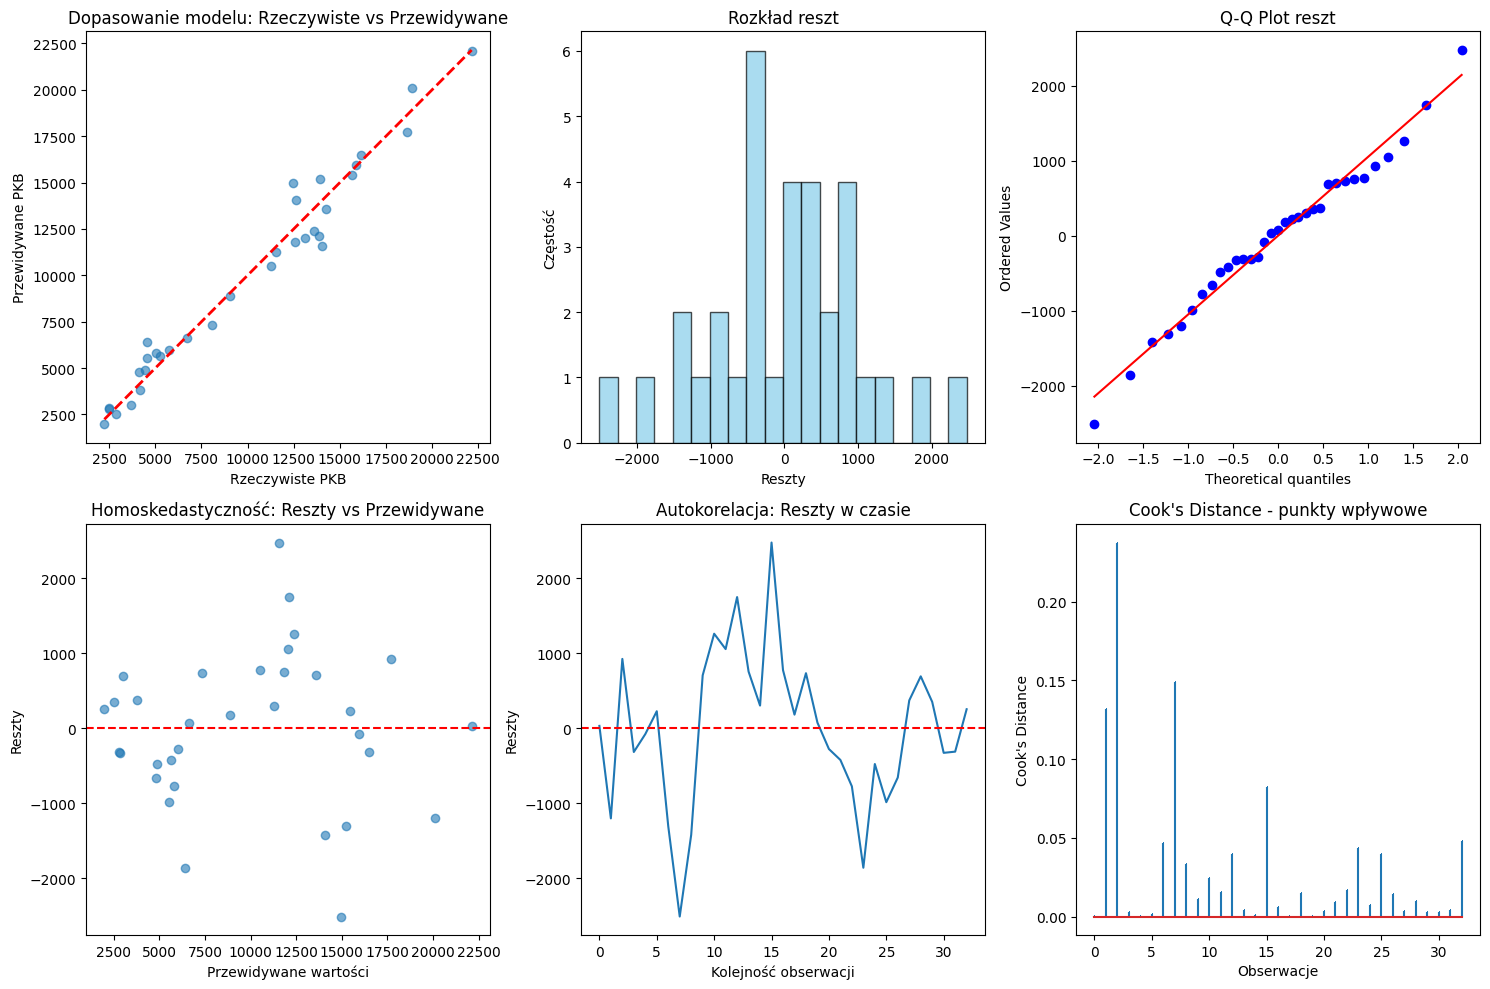


🔍 DIAGNOSTYKA MODELU 1:
• Test Durbina-Watsona: 1.003 (możliwa autokorelacja)
• Współczynniki VIF (multikolinearność):
        Zmienna          VIF
          const 31930.590104
      inflation     3.145143
   unemployment     2.171583
     population     2.284631
life_expectancy     5.804841
• Wpływowe obserwacje (Cook's distance > 0.121): 3

🎯 MODEL 2: Inflacja jako zmienna zależna
                            OLS Regression Results                            
Dep. Variable:              inflation   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     16.34
Date:                Thu, 09 Oct 2025   Prob (F-statistic):           5.16e-07
Time:                        13:34:52   Log-Likelihood:                -119.03
No. Observations:                  33   AIC:                             248.1
Df Residuals:                      28   BIC:                

In [24]:
# --- 7. REGRESJA LINIOWA I DIAGNOSTYKA MODELI ---
print("\n" + "="*60)
print("📈 REGRESJA LINIOWA I DIAGNOSTYKA MODELI")
print("="*60)

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
import scipy.stats as stats

# Przygotowanie danych - usuwanie braków
regression_data = df[["gdp_per_capita", "inflation", "unemployment", "population", "life_expectancy"]].dropna()

if len(regression_data) < 10:
    print("⚠️ Za mało danych do regresji")
else:
    print(f"📊 Dane do regresji: {len(regression_data)} obserwacji")

    # --- MODEL 1: PKB jako zmienna zależna ---
    print("\n" + "="*50)
    print("🎯 MODEL 1: PKB per capita jako zmienna zależna")
    print("="*50)

    X1 = regression_data[["inflation", "unemployment", "population", "life_expectancy"]]
    X1 = sm.add_constant(X1)  # dodanie interceptu
    y1 = regression_data["gdp_per_capita"]

    model1 = sm.OLS(y1, X1).fit()

    print(model1.summary())

    # --- Wizualizacja dopasowania ---
    plt.figure(figsize=(15, 10))

    # Scatterplot: rzeczywiste vs przewidywane wartości
    plt.subplot(2, 3, 1)
    predicted = model1.predict(X1)
    plt.scatter(y1, predicted, alpha=0.6)
    plt.plot([y1.min(), y1.max()], [y1.min(), y1.max()], 'r--', lw=2)
    plt.xlabel('Rzeczywiste PKB')
    plt.ylabel('Przewidywane PKB')
    plt.title('Dopasowanie modelu: Rzeczywiste vs Przewidywane')

    # --- Diagnostyka reszt ---
    residuals = model1.resid

    # Histogram reszt
    plt.subplot(2, 3, 2)
    plt.hist(residuals, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.xlabel('Reszty')
    plt.ylabel('Częstość')
    plt.title('Rozkład reszt')

    # Q-Q plot reszt
    plt.subplot(2, 3, 3)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q Plot reszt')

    # Reszty vs przewidywane wartości (homoskedastyczność)
    plt.subplot(2, 3, 4)
    plt.scatter(predicted, residuals, alpha=0.6)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Przewidywane wartości')
    plt.ylabel('Reszty')
    plt.title('Homoskedastyczność: Reszty vs Przewidywane')

    # Autokorelacja reszt
    plt.subplot(2, 3, 5)
    plt.plot(residuals.values)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Kolejność obserwacji')
    plt.ylabel('Reszty')
    plt.title('Autokorelacja: Reszty w czasie')

    # Cook's distance
    plt.subplot(2, 3, 6)
    influence = model1.get_influence()
    cooks_d = influence.cooks_distance[0]
    plt.stem(range(len(cooks_d)), cooks_d, markerfmt=",")
    plt.xlabel('Obserwacje')
    plt.ylabel("Cook's Distance")
    plt.title("Cook's Distance - punkty wpływowe")

    plt.tight_layout()
    plt.show()

    # --- Metryki diagnostyczne ---
    print("\n🔍 DIAGNOSTYKA MODELU 1:")

    # Test Durbina-Watsona (autokorelacja)
    dw = durbin_watson(residuals)
    print(f"• Test Durbina-Watsona: {dw:.3f} ({'brak autokorelacji' if 1.5 < dw < 2.5 else 'możliwa autokorelacja'})")

    # VIF (multikolinearność)
    print("• Współczynniki VIF (multikolinearność):")
    vif_data = pd.DataFrame()
    vif_data["Zmienna"] = X1.columns
    vif_data["VIF"] = [variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])]
    print(vif_data.to_string(index=False))

    # Cook's distance - punkty wpływowe
    influential_obs = np.where(cooks_d > 4/len(X1))[0]
    print(f"• Wpływowe obserwacje (Cook's distance > {4/len(X1):.3f}): {len(influential_obs)}")

    # --- MODEL 2: Inflacja jako zmienna zależna ---
    print("\n" + "="*50)
    print("🎯 MODEL 2: Inflacja jako zmienna zależna")
    print("="*50)

    X2 = regression_data[["gdp_per_capita", "unemployment", "population", "life_expectancy"]]
    X2 = sm.add_constant(X2)
    y2 = regression_data["inflation"]

    model2 = sm.OLS(y2, X2).fit()
    print(model2.summary())

    # --- Wnioski i rekomendacje ---
    print("\n" + "="*60)
    print("💡 WNIOSKI I REKOMENDACJE")
    print("="*60)

    print("1. 📈 ANALIZA MULTIKOLINEARNOŚCI:")
    high_vif = vif_data[vif_data["VIF"] > 10]
    if len(high_vif) > 0:
        print(f"   ⚠️ Wysoka multikolinearność: {list(high_vif['Zmienna'])}")
        print("   💡 Zalecenie: Usuń zmienne lub użyj regularyzacji")
    else:
        print("   ✅ Brak silnej multikolinearności")

    print("\n2. 📊 JAKOŚĆ DOPASOWANIA:")
    print(f"   • R²: {model1.rsquared:.3f}")
    print(f"   • Adjusted R²: {model1.rsquared_adj:.3f}")

    print("\n3. 🎯 PUNKTY WPŁYWOWE:")
    if len(influential_obs) > 0:
        print(f"   ⚠️ {len(influential_obs)} wpływowych obserwacji - sprawdź czy nie są błędami")
    else:
        print("   ✅ Brak znaczących punktów wpływowych")



print("\n" + "="*60)
print("✅ REGRESJA LINIOWA ZAKOŃCZONA")
print("="*60)

📊 Opis statystyczny Pandas:
count    33.000000
mean      1.250932
std       1.614192
min       0.000218
25%       0.087300
50%       0.466700
75%       2.182800
max       4.987500
Name: mid, dtype: float64

🔸 Mediana: 0.4667
🔸 Odchylenie standardowe: 1.614191607953539


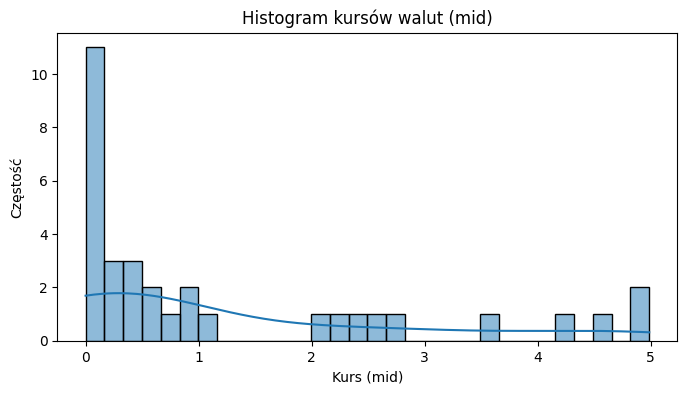

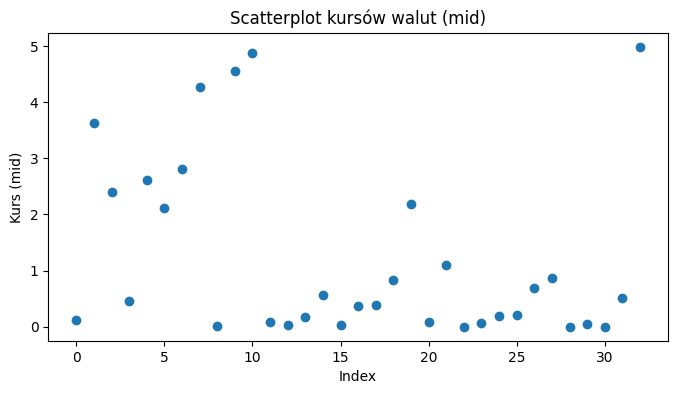

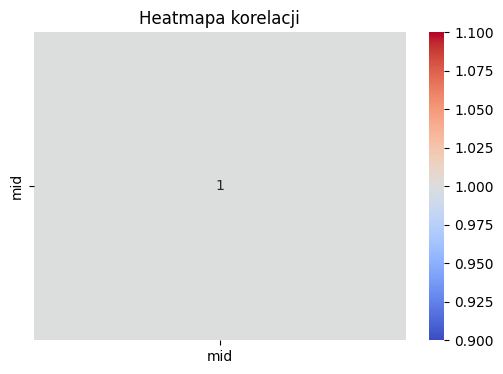

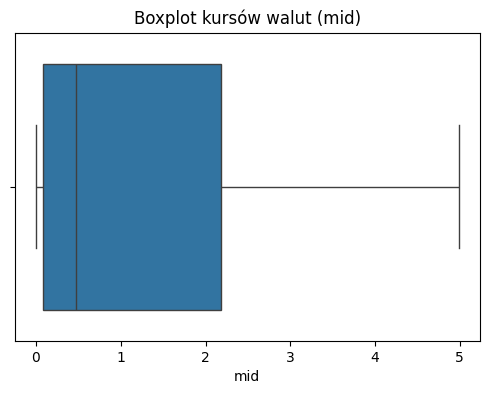

🔎 Liczba outlierów (IQR): 0
🔎 Liczba outlierów (Z-score > 3): 0


In [ ]:


#STARY KOD DOTYCZYL NBP A NIE WORLDBANK

# --- Eksploracyjna Analiza Danych (EDA) ---


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Opis statystyczny Pandas
print("📊 Opis statystyczny Pandas:")
print(df["mid"].describe())
print("\n🔸 Mediana:", df["mid"].median())
print("🔸 Odchylenie standardowe:", df["mid"].std())

# 2. NumPy: logarytmy, normalizacja, standaryzacja
mid_values = df["mid"].values

log_mid = np.log(mid_values)
normalized_mid = (mid_values - mid_values.min()) / (mid_values.max() - mid_values.min())
standardized_mid = (mid_values - mid_values.mean()) / mid_values.std()

# 3. Wizualizacje

# Histogram
plt.figure(figsize=(8, 4))
sns.histplot(df["mid"], bins=30, kde=True)
plt.title("Histogram kursów walut (mid)")
plt.xlabel("Kurs (mid)")
plt.ylabel("Częstość")
plt.show()

# Scatterplot (dla przykładu, jeśli byłaby data – tu losowy indeks)
plt.figure(figsize=(8, 4))
plt.scatter(df.index, df["mid"])
plt.title("Scatterplot kursów walut (mid)")
plt.xlabel("Index")
plt.ylabel("Kurs (mid)")
plt.show()

# Heatmapa korelacji (tylko jeśli więcej zmiennych liczbowych)
if "mid" in df.columns:
    numeric_df = df.select_dtypes(include=[np.number])
    plt.figure(figsize=(6, 4))
    sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
    plt.title("Heatmapa korelacji")
    plt.show()

# 4. Wykrywanie wartości odstających (outlierów)

# Boxplot
plt.figure(figsize=(6, 4))
sns.boxplot(x=df["mid"])
plt.title("Boxplot kursów walut (mid)")
plt.show()

# IQR
Q1 = df["mid"].quantile(0.25)
Q3 = df["mid"].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = df[(df["mid"] < Q1 - 1.5 * IQR) | (df["mid"] > Q3 + 1.5 * IQR)]
print(f"🔎 Liczba outlierów (IQR): {len(outliers_iqr)}")

# Z-score
z_scores = (df["mid"] - df["mid"].mean()) / df["mid"].std()
outliers_z = df[np.abs(z_scores) > 3]
print(f"🔎 Liczba outlierów (Z-score > 3): {len(outliers_z)}")


PONIZEJ NA BRUDNO ROBOCZA WERSJA

In [ ]:

import pandas as pd
import numpy as np
import requests
import re
from pydantic import BaseModel, ValidationError

# Przykład pobrania danych (API NBP kursy walut)
url = "https://api.nbp.pl/api/exchangerates/tables/A?format=json"
data = requests.get(url).json()
df = pd.json_normalize(data[0]['rates'])
print(df.head())

# Walidacja kolumny waluty
class Currency(BaseModel):
    code: str

try:
    for c in df['code']:
        Currency(code=c)
except ValidationError as e:
    print(e)

# Prosta serializacja
df.to_csv("data.csv", index=False)


             currency code     mid
0     bat (Tajlandia)  THB  0.1130
1   dolar amerykański  USD  3.6295
2  dolar australijski  AUD  2.3949
3     dolar Hongkongu  HKD  0.4666
4    dolar kanadyjski  CAD  2.6127


 2. EDA (eksploracja danych)

             mid
count  33.000000
mean    1.249594
std     1.612480
min     0.000217
25%     0.087300
50%     0.466600
75%     2.179100
max     4.970800


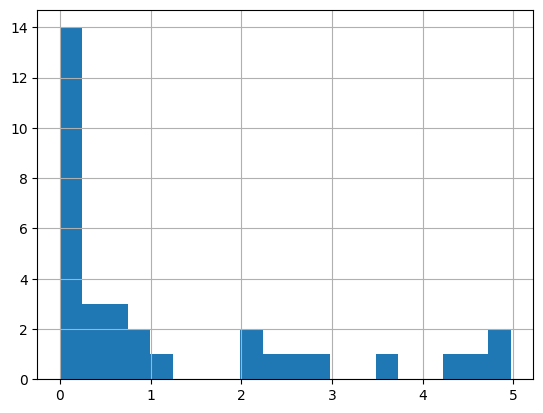

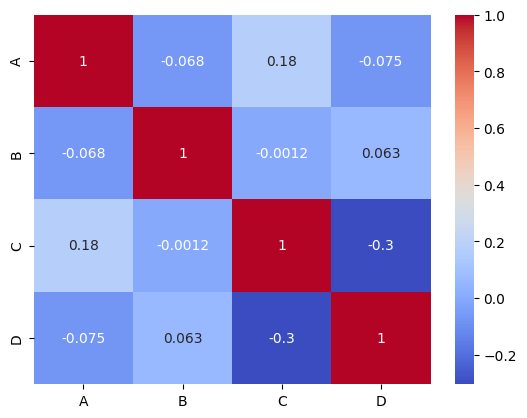

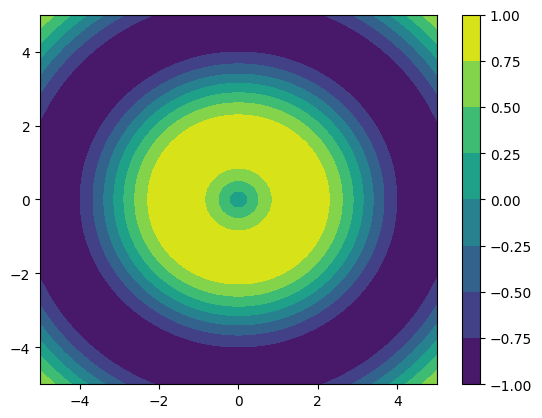

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

print(df.describe())

# Histogram
df['mid'].hist(bins=20)
plt.show()

# Heatmapa korelacji (przykład na sztucznych danych)
df2 = pd.DataFrame(np.random.randn(100, 4), columns=list("ABCD"))
sns.heatmap(df2.corr(), annot=True, cmap="coolwarm")
plt.show()

# Meshgrid + contour plot
x = np.linspace(-5, 5, 50)
y = np.linspace(-5, 5, 50)
X, Y = np.meshgrid(x, y)
Z = np.sin(np.sqrt(X**2 + Y**2))

plt.contourf(X, Y, Z, cmap="viridis")
plt.colorbar()
plt.show()


3. Statystyka klasyczna

95% CI: (np.float64(98.69413389083786), np.float64(103.90888880610567))
Shapiro-Wilk: ShapiroResult(statistic=np.float64(0.9774151949589392), pvalue=np.float64(0.4488425719013703))
T-test: TtestResult(statistic=np.float64(0.9783452568427398), pvalue=np.float64(0.3327093449779359), df=np.int64(49))


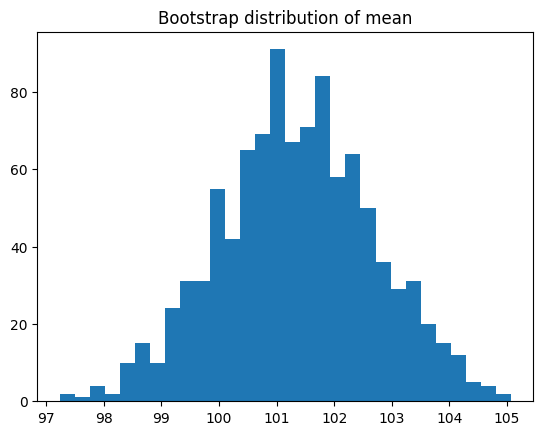

In [ ]:

from scipy import stats

# Przedział ufności dla średniej
sample = np.random.normal(loc=100, scale=10, size=50)
conf_int = stats.norm.interval(0.95, loc=np.mean(sample), scale=stats.sem(sample))
print("95% CI:", conf_int)

# Test normalności
print("Shapiro-Wilk:", stats.shapiro(sample))

# Test t
print("T-test:", stats.ttest_1samp(sample, 100))

# Bootstrap
boot_means = []
for _ in range(1000):
    boot_sample = np.random.choice(sample, size=len(sample), replace=True)
    boot_means.append(np.mean(boot_sample))
plt.hist(boot_means, bins=30)
plt.title("Bootstrap distribution of mean")
plt.show()


4. Regresja liniowa

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     990.8
Date:                Thu, 25 Sep 2025   Prob (F-statistic):           1.05e-33
Time:                        15:57:34   Log-Likelihood:                -103.75
No. Observations:                  50   AIC:                             211.5
Df Residuals:                      48   BIC:                             215.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7493      0.548     12.315      0.0

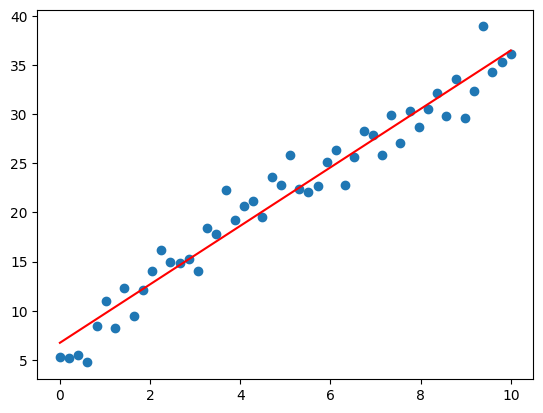

In [ ]:
# =======================================
# 4. Regresja liniowa
# =======================================
import statsmodels.api as sm

X = np.linspace(0, 10, 50)
Y = 3*X + 7 + np.random.normal(0, 2, 50)

X_ = sm.add_constant(X)
model = sm.OLS(Y, X_).fit()
print(model.summary())

plt.scatter(X, Y)
plt.plot(X, model.predict(X_), color="red")
plt.show()


5. Regularyzacja (Ridge, Lasso)

In [ ]:

from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

X = df2.drop("A", axis=1)
y = df2["A"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

ridge = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
lasso = make_pipeline(StandardScaler(), Lasso(alpha=0.1))

ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

print("Ridge R2:", ridge.score(X_test, y_test))
print("Lasso R2:", lasso.score(X_test, y_test))


Ridge R2: -0.1662488415345651
Lasso R2: -0.10731336350517173


6. Szeregi czasowe

/tmp/ipython-input-3685064161.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range("2020-01-01", periods=100, freq="M")


ADF test: (np.float64(0.6266193983771053), np.float64(0.9882537006790334), 11, 88, {'1%': np.float64(-3.506944401824286), '5%': np.float64(-2.894989819214876), '10%': np.float64(-2.584614550619835)}, np.float64(568.1195638563936))
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -322.395
Date:                Thu, 25 Sep 2025   AIC                            650.791
Time:                        15:58:17   BIC                            658.576
Sample:                    01-31-2020   HQIC                           653.941
                         - 04-30-2028                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------

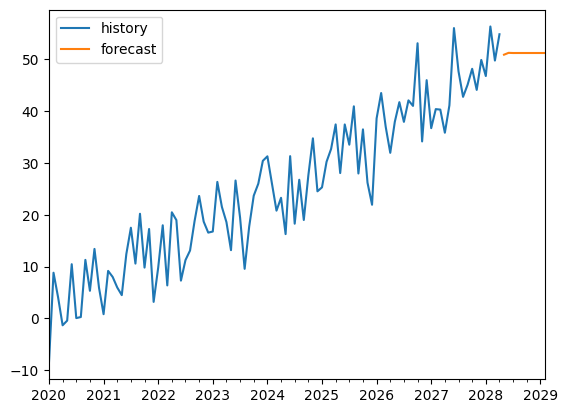

In [ ]:

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# Dane sztuczne: trend + szum
dates = pd.date_range("2020-01-01", periods=100, freq="M")
ts = pd.Series(0.5*np.arange(100) + np.random.normal(0, 5, 100), index=dates)

# Test stacjonarności
print("ADF test:", adfuller(ts))

# ARIMA model
model = ARIMA(ts, order=(1,1,1)).fit()
print(model.summary())

forecast = model.forecast(10)
ts.plot(label="history")
forecast.plot(label="forecast")
plt.legend()
plt.show()


7. Prezentacja wyników

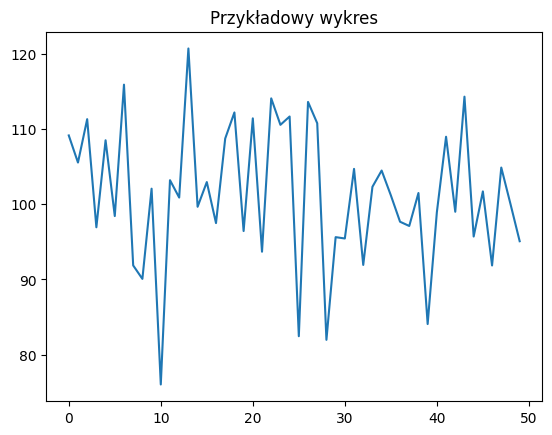

In [ ]:

# Zapis do pliku
df.describe().to_csv("report.csv")

# Przykładowy wykres PNG
plt.plot(sample)
plt.title("Przykładowy wykres")
plt.savefig("report.png")
